# <ins> HLoG-VBGMM:

* HLoG-VBGMM is a blob detector based on Laplacian of Gaussian for filtering and image enhancement, Hessian analysis for blob delineation, and VBGMM for clustering. 

In [30]:
# import librairies
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import  ListedColormap
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from python.utils import get_index_matrix_3D, get_mean_value, get_R_value, get_S_value, z_score_normalisation, optimale_scale_identification, hessian, get_Ht
from scipy import ndimage
from skimage.measure import label, regionprops_table
from sklearn.mixture import BayesianGaussianMixture
%matplotlib ipympl

## 1 - Import and read the data

In [18]:
# mri and mask paths
mri_path = './input/A_mri.nii.gz'
mask = './input/A_mask.nii.gz'  # 0 = background; 1 = cortex; 2 = medulla

# read the .nii.gz file with simpleITK
mri = sitk.ReadImage(mri_path)
mask = sitk.ReadImage(mask)

# convert to numpy array
mri = sitk.GetArrayFromImage(mri)
mask = sitk.GetArrayFromImage(mask)

# normalisation
mri = z_score_normalisation(mri)

# use matlab format
Nz, Ny, Nx = mri.shape

# middle plan slice number (for plots) 
mid_plan = int(Nz / 2)

# parameters:
resolution = 30 # enter the resolution of the mri here 
factor = resolution / 30     
radius_min = 2.0 / factor
radius_max = 5.0 / factor
vol_min = (4 / 3) * np.pi * radius_min**3 
vol_max = (4 / 3) * np.pi * radius_max**3

Text(0.5, 1.0, 'Middle plan MRI at 30-micron resolution')

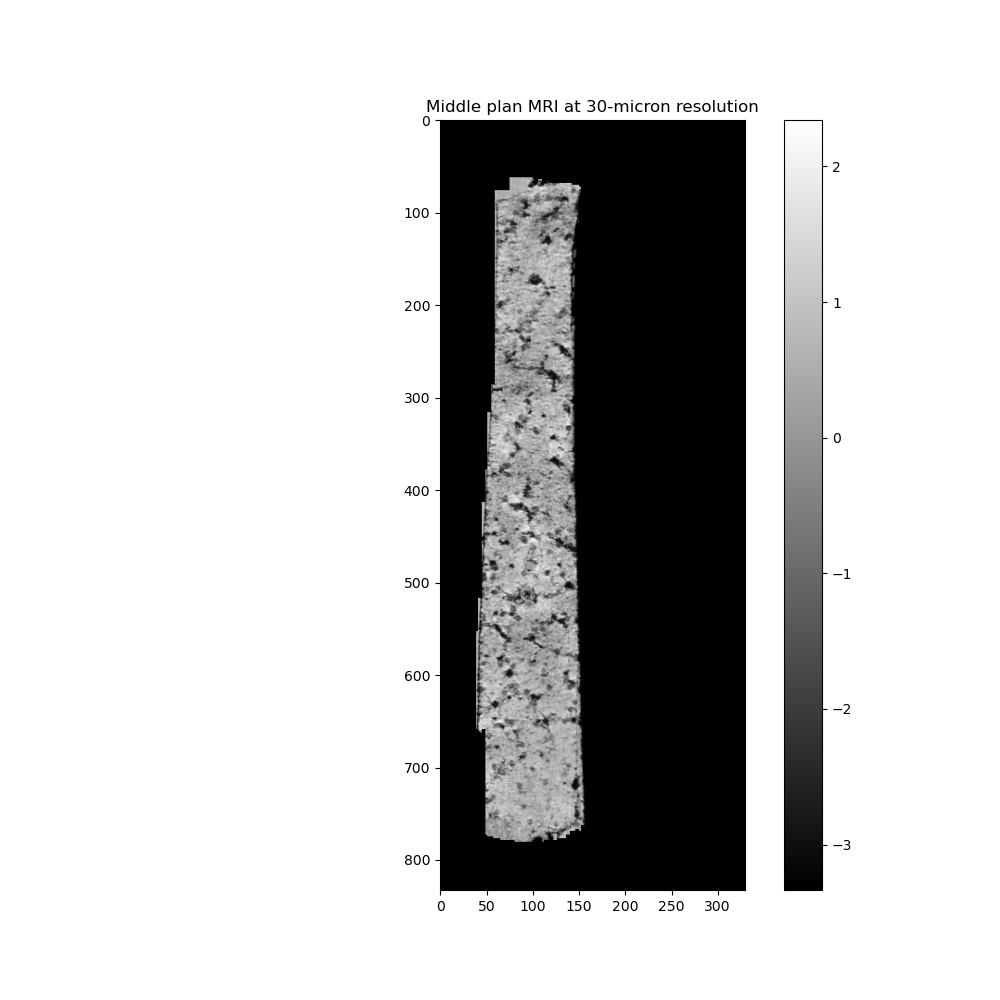

In [19]:
# quick visualisation
plt.figure(figsize=(10, 10))
plt.imshow(mri[mid_plan, :, :], cmap='gray')
plt.colorbar()
plt.title('Middle plan MRI at ' + str(resolution) + '-micron resolution')

# 2 - Hessian analysis for blob segmentation and scale optimisation

Given a 3-D image $f : \mathbb{R^3} → \mathbb{R}$, the hessian matrix of the voxel $(x, y, z)$, noted $H(x, y, z)$, is defined as:

$$ H(x, y, z) = \nabla . \nabla f(x, y, z)$$

As all the voxels of a blob have a negative definite hessian matrix, we define the binary indicator matrix $I$ such that $I(x, y, z) = 1$ if the voxel $(x, y, z)$ has a negative definte hessian matrix, and I(x, y, z) = 0 otherwise. 

Hessian analysis can also be used to identify the optimal scale parameter $\sigma$. In our case, we assume that all glomeruli have approximately the same size. As a result, we optimise a single scale parameter, unique for all blobs. To do so, we use the average LoG value of blob candidates $B_{LoG}$, defined as:

$$ B_{LoG}(\sigma) = \frac{\sum_{x, y, z} L(x, y, z; \sigma) \times I(x, y, z; \sigma)}{\sum_{x, y, z}I(x, y, z; \sigma)}$$

Finally, by iterating through a range of scales values, we obtain the optimum scale:

$$\sigma^* = \text{argmax}_{\sigma} (B_{LoG}(\sigma))$$


In [20]:
_, _, LoG_norm, I, lambda1, lambda2, lambda3 = optimale_scale_identification(mri, mask)

In [21]:
# Hessian: 
gxx, gxy, gxz, gyy, gyz, gzz = hessian(LoG_norm)

# 3 - Features extraction


In [22]:
labels = label(I)
list_properties = ['area','bbox', 'label', 'centroid', 'EquivDiameter', 'axis_major_length', 'inertia_tensor_eigvals', 'coords']
df = pd.DataFrame(regionprops_table(labels, properties = list_properties))

# remove the blobs that are too small or too big
df = df[(df['area'] <= vol_max) & (df['area'] >= vol_min)] 
df = df.reset_index(drop=True)

# add S, R, and mean_intensity columns: (we have L1 < L2 < L3 < 0 ie |L3| < |L2| < |L1|)
df.insert(1, "S", '')
df.insert(2, 'Rb', '') #  To measure L3 / sqrt(L2 * L1)
df.insert(3, "R1", '') # To measure L3 / L1
df.insert(4, "Ra", '') # To measure L2 / L1
df.insert(5, "S_max", 0)
df.insert(6, "Rb_max", 0)
df.insert(7, "R1_max", 0)
df.insert(8, "Ra_max", 0)
df.insert(9, "S_mean", 0)
df.insert(10, "Rb_mean", 0)
df.insert(11, "R1_mean", 0)
df.insert(12, "Ra_mean", 0)
df.insert(13, "mean_intensity", 0)
df.insert(14, "Ht", '')
df.insert(15, "L1", 0)
df.insert(16, "L2", 0)
df.insert(17, "L3", 0)
df.insert(18, "Rb_t", 0)
df.insert(19, "R1_t", 0)
df.insert(20, "Ra_t", 0)
df.insert(21, "S_t", 0)

denominator_Rb = np.sqrt(np.abs(lambda2*lambda1))

for i in range(len(df)):
    # S features:
    df["S"][i] = get_S_value(lambda1, lambda2, lambda3, df["coords"][i])
    df["S_max"][i] = np.max(df["S"][i])
    df["S_mean"][i] = np.mean(df["S"][i])
    # Rb features:
    df["Rb"][i] = get_R_value(lambda3, denominator_Rb, df["coords"][i])
    df["Rb_max"][i] = np.max(df["Rb"][i])
    df["Rb_mean"][i] = np.mean(df["Rb"][i])
    # R1 features:
    df["R1"][i] = get_R_value(lambda3, lambda1, df["coords"][i])
    df["R1_max"][i] = np.max(df["R1"][i])
    df["R1_mean"][i] = np.mean(df["R1"][i])
    # R2 features:
    df["Ra"][i] = get_R_value(lambda2, lambda1, df["coords"][i])
    df["Ra_max"][i] = np.max(df["Ra"][i])
    df["Ra_mean"][i] = np.mean(df["Ra"][i])
    # mean_intensity feature:
    df["mean_intensity"][i] = get_mean_value(LoG_norm, df["coords"][i])
    # regional features from Ht:
    df["Ht"][i] = get_Ht(gxx, gxy, gxz, gyy, gyz, gzz, df["coords"][i])
    # eigenvalues of Ht:
    df["L1"][i], df["L2"][i], df["L3"][i] = np.linalg.eigvalsh(df["Ht"][i])
    # Regional blob features:
    df["Rb_t"][i] = np.abs(df["L3"][i]) / np.sqrt(df["L1"][i] * df["L2"][i]) 
    df["R1_t"][i] = np.abs(df["L3"][i]) / np.abs(df["L1"][i]) 
    df["Ra_t"][i] = np.abs(df["L2"][i]) / np.abs(df["L1"][i])
    df["S_t"][i] = np.sqrt(df["L1"][i]**2 + df["L2"][i]**2 + df["L3"][i]**2)

Text(0.5, 0.98, 'Steps of HLoG to pre-segment blob candidates')

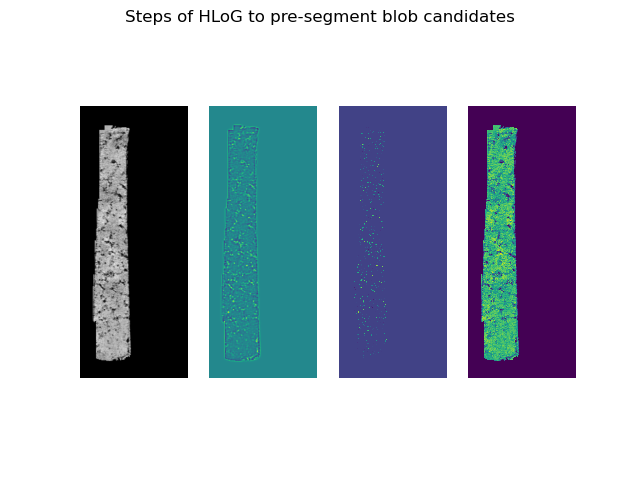

In [23]:
# counting results
count_blob_candidates = len(df)

# generate mask for blob candidates:
mask_blob = np.zeros(mri.shape)

for i in range(count_blob_candidates):
    for j in range(len(df.coords[df.index[i]])):
        x, y, z = df.coords[df.index[i]][j]
        mask_blob[(x, y, z)] = 1


# plot of HLoG steps
f, axarr = plt.subplots(1, 4)
axarr[0].imshow(mri[mid_plan, :, :], cmap="gray")
axarr[0].axis('off')
axarr[1].imshow(LoG_norm[mid_plan, :, :])
axarr[1].axis('off')
axarr[2].imshow((LoG_norm * I)[mid_plan, :, :], interpolation='nearest')
axarr[2].axis('off')
mat =  np.copy(mri)
mat[np.where(mask_blob == 1)] = 1
axarr[3].imshow(mat[mid_plan, :, :], interpolation='nearest')
axarr[3].axis('off')
plt.suptitle('Steps of HLoG to pre-segment blob candidates')

# 4 - Clustering with VBGMM

In [24]:
vbgmm = BayesianGaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(df[["area", "S_max", "Rb_t"]])

In [25]:
# check the mean values
print(vbgmm.means_)

[[40.47087741  0.21892687  0.4626371 ]
 [61.68797974  0.23645053  0.5548099 ]]


In [26]:
# clustering
labels_vbgmm = vbgmm.predict(df[["area", "S_max", "Rb_t"]])
array_vbgmm = np.reshape(labels_vbgmm, (len(labels_vbgmm), 1))

# Add labels to dataframe:
df[["labels_vbgmm"]]= array_vbgmm

In [27]:
# score: we keep the cluster with the highest R1_max mean value:
if vbgmm.means_[0, 2] > vbgmm.means_[1, 2]:
    n_glom = count_blob_candidates - np.sum(array_vbgmm)
    n_non_glom = np.sum(array_vbgmm)
    df_glom = df[df["labels_vbgmm"] == 0]
    df_non_glom = df[df["labels_vbgmm"] == 1]
else:
    n_glom = np.sum(array_vbgmm)
    n_non_glom = count_blob_candidates - np.sum(array_vbgmm)
    df_glom = df[df["labels_vbgmm"] == 1]
    df_non_glom = df[df["labels_vbgmm"] == 0]

print("The total number of glomeruli is: " + str(n_glom))

The total number of glomeruli is: 2245


/var/folders/1g/6lhzy_357n72_7qbq_2rjvsc0000gn/T/ipykernel_55652/2943019821.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot()


(-0.5, 989.5, 832.5, -0.5)

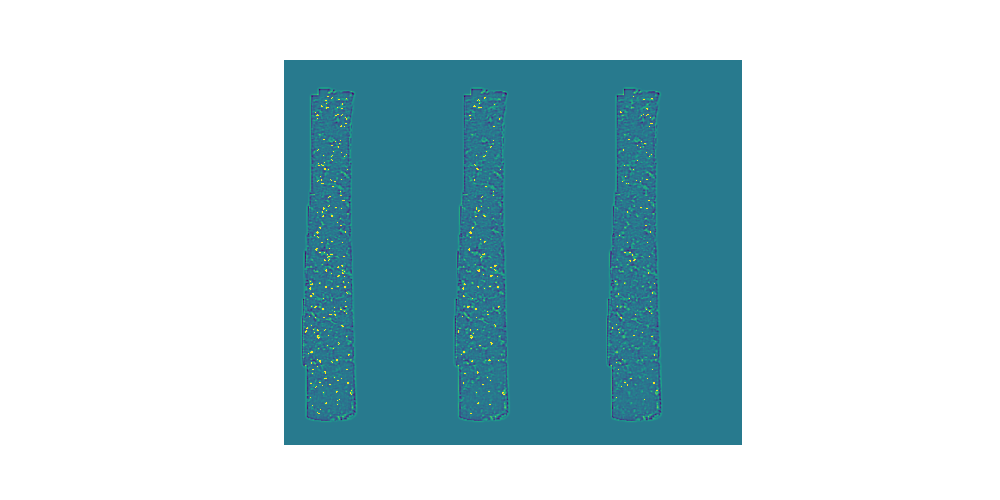

In [28]:
# generate masks and plot the segmentation result
count_glom = len(df_glom)
count_non_glom = len(df_non_glom)

# generate masks
mask_glom = np.zeros(mri.shape)
mask_non_glom = np.zeros(mri.shape)


for i in range(count_glom):
    for j in range(len(df_glom.coords[df_glom.index[i]])):
        x, y, z = df_glom.coords[df_glom.index[i]][j]
        mask_glom[(x, y, z)] = 1

for i in range(count_non_glom):
    for j in range(len(df_non_glom.coords[df_non_glom.index[i]])):
        x, y, z = df_non_glom.coords[df_non_glom.index[i]][j]
        mask_non_glom[(x, y, z)] = 1


mat1 =  np.copy(LoG_norm)
mat1[np.where(mask_blob == 1)] = 1

mat2 =  np.copy(LoG_norm)
mat2[np.where(mask_glom == 1)] = 1

mat3 =  np.copy(LoG_norm)
mat3[np.where(mask_non_glom == 1)] = 1

plot_matrix = np.concatenate((mat1, mat2, mat3), axis=2)

plt.subplot()
plt.figure(figsize=(10, 5))
plt.imshow(plot_matrix[mid_plan, :, :], interpolation='nearest')
plt.axis('off')

Text(0.5, 0.98, 'VBGMM clustering')

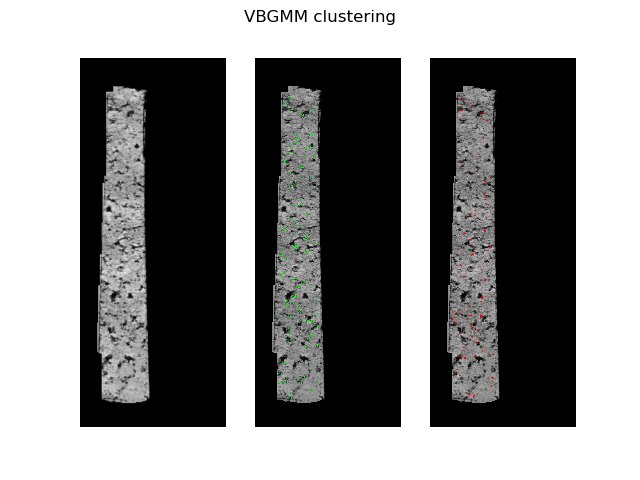

In [31]:
# plot for VBGMM clustering 

# new colormaps:
mymap = mpl.colormaps['gray'].resampled(256)
newcolors1 = mymap(np.linspace(0, 1, 256))
newcolors2 = mymap(np.linspace(0, 1, 256))
#pink = np.array([248/256, 24/256, 148/256, 1])
red = np.array([256/256, 1/256, 1/256, 1])
green = np.array([1/256, 256/256, 1/256, 1])
newcolors1[255, :] = green
newcolors2[255, :] = red
newcmp1 = ListedColormap(newcolors1)
newcmp2 = ListedColormap(newcolors2)

mat1 =  np.copy(mri)
mat1[np.where(mask_glom == 1)] = np.max(mri)

mat2 =  np.copy(mri)
mat2[np.where(mask_non_glom == 1)] = np.max(mri)

slice = 200

# plot for VBGMM clustering 
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(mri[slice, :, :], cmap="gray")
axarr[0].axis('off')
axarr[1].imshow(mat1[slice, :, :], cmap=newcmp1, interpolation="nearest")
axarr[1].axis('off')
axarr[2].imshow(mat2[slice, :, :], cmap=newcmp2, interpolation="nearest")
axarr[2].axis('off')
plt.suptitle('VBGMM clustering')